In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
import sys
sys.path.append('scripts/')
from simulation_based_likelihood import *
from synthetic_data import *

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 24  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 24  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 30  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 34  # Font size of title

# Simba-CL surfaces

Here we show how to reproduce the profile likelihood surfaces from the paper. As a guiding example we consider $\beta_{\lambda}$.

In [5]:
# Small population, basic covariates effect, basic initial variance 
covariates_n = 2

M = 2
N = 100
covmean = 0
initial_infection_rate = 0.1
T = 90
epsilon_value = 0.001

In [6]:
# generate covariates
individuals = np.linspace(0, N-1, N, dtype = int)+1

W = np.random.normal(1, 0, (N, 1))
for i in range(covariates_n-1):

    cov = np.random.normal(covmean, 1, (N, 1))
    W = np.concatenate((W, cov), axis =1)

W_tensor = tf.convert_to_tensor(W, dtype = tf.float32)

input_0      = tuple([W_tensor])
input_kernel = tuple([W_tensor])

# generate the data
model = compartmental_model(N, input_0, input_kernel, SIS_initial, SIS_transition)

beta_0      = tf.convert_to_tensor( [-np.log((1/initial_infection_rate)-1), +0], dtype = tf.float32 )
beta_lambda = tf.convert_to_tensor( [-1,           +2],      dtype = tf.float32 )  
beta_gamma  = tf.convert_to_tensor( [-1,           -1],      dtype = tf.float32 )  
epsilon     = tf.convert_to_tensor( [epsilon_value],                  dtype = tf.float32 )  

parameters_0 = tuple([beta_0])
parameters_kernel = beta_lambda, beta_gamma, epsilon

q_0      = tf.convert_to_tensor([0.0, 0.0], dtype = tf.float32)   
q_static = tf.convert_to_tensor([0.6, 0.4], dtype = tf.float32)

q_0_expanded      = tf.expand_dims(tf.expand_dims(q_0, axis = 0), axis = 0)
q_static_expanded = tf.expand_dims(tf.expand_dims(q_static, axis = 0), axis = 0)

q_dynamic = tf.concat((q_0_expanded*tf.ones((1, N, M)), q_static_expanded*tf.ones((T, N, M))), axis =0)

parameters_emission = tuple([q_static])

seed_simulation = tfp.random.split_seed( 123, n = 1, salt = 'test')

x, y = sim(model, parameters_0, parameters_kernel, q_dynamic, T, seed_simulation[0][0])

seed_test = seed_simulation[0][1]
while tf.reduce_sum(tf.reduce_sum(x, axis =0), axis =0)[1]<10:
    seed_test = tfp.random.split_seed( seed_test, n = 1, salt = 'new')
    x, y = sim(model, parameters_0, parameters_kernel, q_dynamic, T, seed_test[0][0])
    seed_test = seed_test[0][1]

We can plot the total observed infected per time step

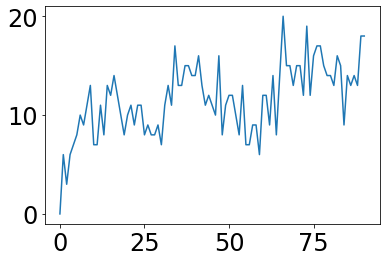

In [7]:
plt.plot(tf.reduce_sum(y, axis = 1)[:,1])

In [8]:
# Grid
# likelihood estimates
parallel_simulations = 100

simulation_likelihood_model = simulation_likelihood(parallel_simulations, N, input_0, input_kernel, SIS_initial, SIS_transition, SIS_emission)

grid_resolution = 20

beta_lambda_1 = np.linspace(-4, 4, grid_resolution)
beta_lambda_2 = np.linspace(-4, 4, grid_resolution)

log_likelihood_approx_beta_lambda = np.zeros((grid_resolution, grid_resolution))

In [9]:
seed_simulation_2 = tfp.random.split_seed( 123, n = grid_resolution, salt = 'test_2')

for i in range(grid_resolution):
    print(i)

    seed_simulation_2_layer2 = tfp.random.split_seed( seed_simulation_2[i][0], n = grid_resolution, salt = 'test_2_layer2')
    
    for j in range(grid_resolution):

        beta_0      = tf.convert_to_tensor( [-np.log((1/initial_infection_rate)-1), +0], dtype = tf.float32 )
        beta_lambda = tf.convert_to_tensor( [beta_lambda_1[i], beta_lambda_2[j]],      dtype = tf.float32 )  
        beta_gamma  = tf.convert_to_tensor( [-1,           -1],      dtype = tf.float32 )  
        epsilon     = tf.convert_to_tensor( [epsilon_value],                  dtype = tf.float32 )  

        parameters_0 = tuple([beta_0])
        parameters_kernel = beta_lambda, beta_gamma, epsilon

        q_0      = tf.convert_to_tensor([0.0, 0.0], dtype = tf.float32)   
        q_static = tf.convert_to_tensor([0.6, 0.4], dtype = tf.float32)

        q_0_expanded      = tf.expand_dims(tf.expand_dims(q_0, axis = 0), axis = 0)
        q_static_expanded = tf.expand_dims(tf.expand_dims(q_static, axis = 0), axis = 0)

        q_dynamic = tf.concat((q_0_expanded*tf.ones((1, N, M)), q_static_expanded*tf.ones((T, N, M))), axis =0)

        parameters_emission = tuple([q_static])

        log_likelihood_approx = run_simulation_likelihood_approx(simulation_likelihood_model, parameters_0, parameters_kernel, parameters_emission, y, seed_simulation_2_layer2[j][0])

        max_log_likelihood = tf.reduce_max(log_likelihood_approx, axis = 0, keepdims = True)
        log_likelihood_individuals = tf.reduce_sum(tf.math.log(tf.reduce_mean(tf.exp(log_likelihood_approx - max_log_likelihood), axis =0)) + tf.reduce_max(log_likelihood_approx, axis = 0))

        log_likelihood_approx_beta_lambda[i,j] = log_likelihood_individuals.numpy()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [10]:
grid_resolution = 20
beta_lambda_1 = np.linspace(-4, 4, grid_resolution)
beta_lambda_2 = np.linspace(-4, 4, grid_resolution)
beta_lambda_1_grid, beta_lambda_2_grid = np.meshgrid(beta_lambda_1, beta_lambda_2, indexing = "ij")

beta_lambda  = np.array([-1, +2])

log_likelihood_experiments_approx_grid_beta_lambda = log_likelihood_approx_beta_lambda

In [12]:
import matplotlib.ticker as ticker

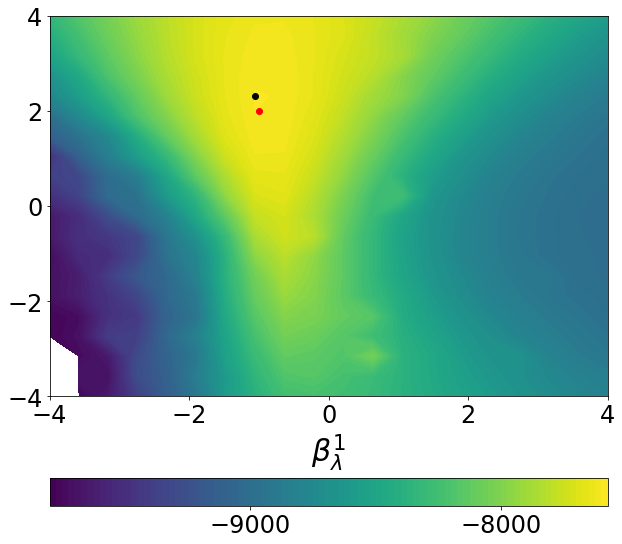

In [13]:
fig, ax = plt.subplots(nrows=1, ncols =1, figsize=(10, 10))

contour2 = ax.contourf(beta_lambda_1_grid, beta_lambda_2_grid, log_likelihood_experiments_approx_grid_beta_lambda, levels=100)
i,j = np.where((log_likelihood_experiments_approx_grid_beta_lambda == np.nanmax(log_likelihood_experiments_approx_grid_beta_lambda)))
i,j = i[0],j[0]
ax.scatter([beta_lambda_1_grid[i,j]], [beta_lambda_2_grid[i,j]], color = "black")
ax.scatter([beta_lambda[0]], [beta_lambda[1]], color = "red")
# ax[1].set_title("Coupled")
ax.set_xlabel(r"$\beta_{\lambda}^{1}$")

cbar = plt.colorbar(contour2, ax = ax, orientation='horizontal')
cbar.locator = ticker.MaxNLocator(nbins=2)  # Show only 2 ticks
cbar.update_ticks()

The above can be iterated on different parameters and on finer grids as in the paper. We report here our studies and how to reproduce the figures in the paper.

## Paper figures

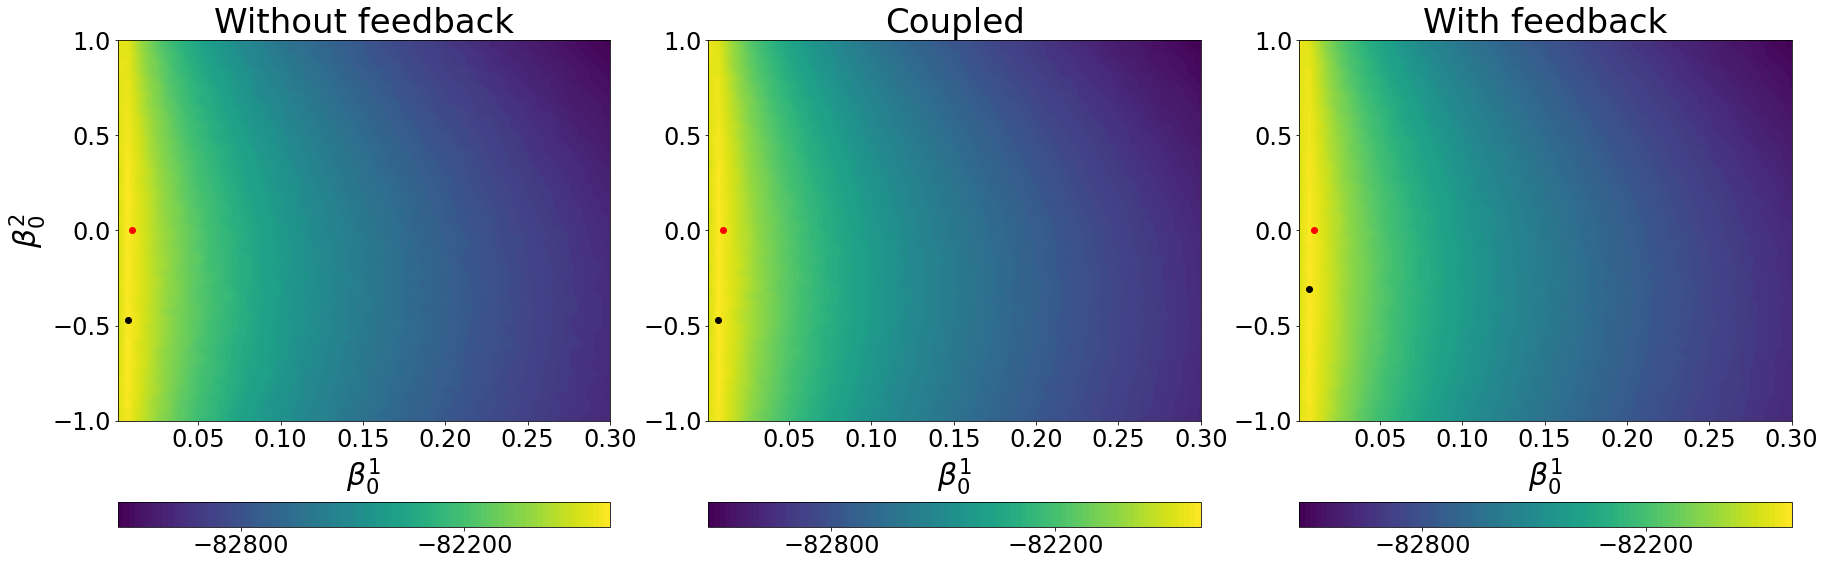

In [15]:
log_likelihood_experiments_approx_grid_beta_0 = (np.load("data/likelihood_grid/log_likelihood_experiments_approx_grid_T100_N1000_initial10_epsilon1_covmean0.npy"))
log_likelihood_experiments_coupled_grid_beta_0 = (np.load("data/likelihood_grid/log_likelihood_experiments_coupled_grid_T100_N1000_initial10_epsilon1_covmean0.npy"))
log_likelihood_experiments_grid_beta_0        = (np.load("data/likelihood_grid/log_likelihood_experiments_grid_T100_N1000_initial10_epsilon1_covmean0.npy"))

grid_resolution = 50
initial_infection_rate = np.linspace( 0.001, 0.3, grid_resolution)
beta_0_2                    = np.linspace(-1,    1,   grid_resolution)
# beta_0_1_grid, beta_0_2_grid = np.meshgrid((-np.log((1/initial_infection_rate)-1)), beta_0_2, indexing = "ij")
beta_0_1_grid, beta_0_2_grid = np.meshgrid(initial_infection_rate, beta_0_2, indexing = "ij")

# beta_0  = np.array([-np.log((1/0.1)-1), +0])
beta_0  = np.array([0.01, +0])

fig, ax = plt.subplots(nrows=1, ncols =3, figsize=(30, 10))

contour1 = ax[0].contourf(beta_0_1_grid, beta_0_2_grid, log_likelihood_experiments_grid_beta_0, levels=100)
i,j = np.where((log_likelihood_experiments_grid_beta_0 == np.nanmax(log_likelihood_experiments_grid_beta_0)))
i,j = i[0],j[0]
ax[0].scatter([beta_0_1_grid[i,j]], [beta_0_2_grid[i,j]], color = "black")
ax[0].scatter([beta_0[0]], [beta_0[1]], color = "red")
ax[0].set_title("Without feedback")
ax[0].set_xlabel(r"$\beta_0^{1}$")
ax[0].set_ylabel(r"$\beta_0^{2}$")

cbar = plt.colorbar(contour1, ax = ax[0], orientation='horizontal')
cbar.locator = ticker.MaxNLocator(nbins=2)  # Show only 2 ticks
cbar.update_ticks()

contour2 = ax[1].contourf(beta_0_1_grid, beta_0_2_grid, log_likelihood_experiments_approx_grid_beta_0, levels=100)
i,j = np.where((log_likelihood_experiments_approx_grid_beta_0 == np.nanmax(log_likelihood_experiments_approx_grid_beta_0)))
i,j = i[0],j[0]
ax[1].scatter([beta_0_1_grid[i,j]], [beta_0_2_grid[i,j]], color = "black")
ax[1].scatter([beta_0[0]], [beta_0[1]], color = "red")
ax[1].set_title("Coupled")
ax[1].set_xlabel(r"$\beta_0^{1}$")

cbar = plt.colorbar(contour2, ax = ax[1], orientation='horizontal')
cbar.locator = ticker.MaxNLocator(nbins=2)  # Show only 2 ticks
cbar.update_ticks()

contour3 = ax[2].contourf(beta_0_1_grid, beta_0_2_grid, log_likelihood_experiments_coupled_grid_beta_0, levels=100)
i,j = np.where((log_likelihood_experiments_coupled_grid_beta_0 == np.nanmax(log_likelihood_experiments_coupled_grid_beta_0)))
i,j = i[0],j[0]
ax[2].scatter([beta_0_1_grid[i,j]], [beta_0_2_grid[i,j]], color = "black")
ax[2].scatter([beta_0[0]], [beta_0[1]], color = "red")
ax[2].set_title("With feedback")
ax[2].set_xlabel(r"$\beta_0^{1}$")

cbar = plt.colorbar(contour3, ax = ax[2], orientation='horizontal')
cbar.locator = ticker.MaxNLocator(nbins=2)  # Show only 2 ticks
cbar.update_ticks()

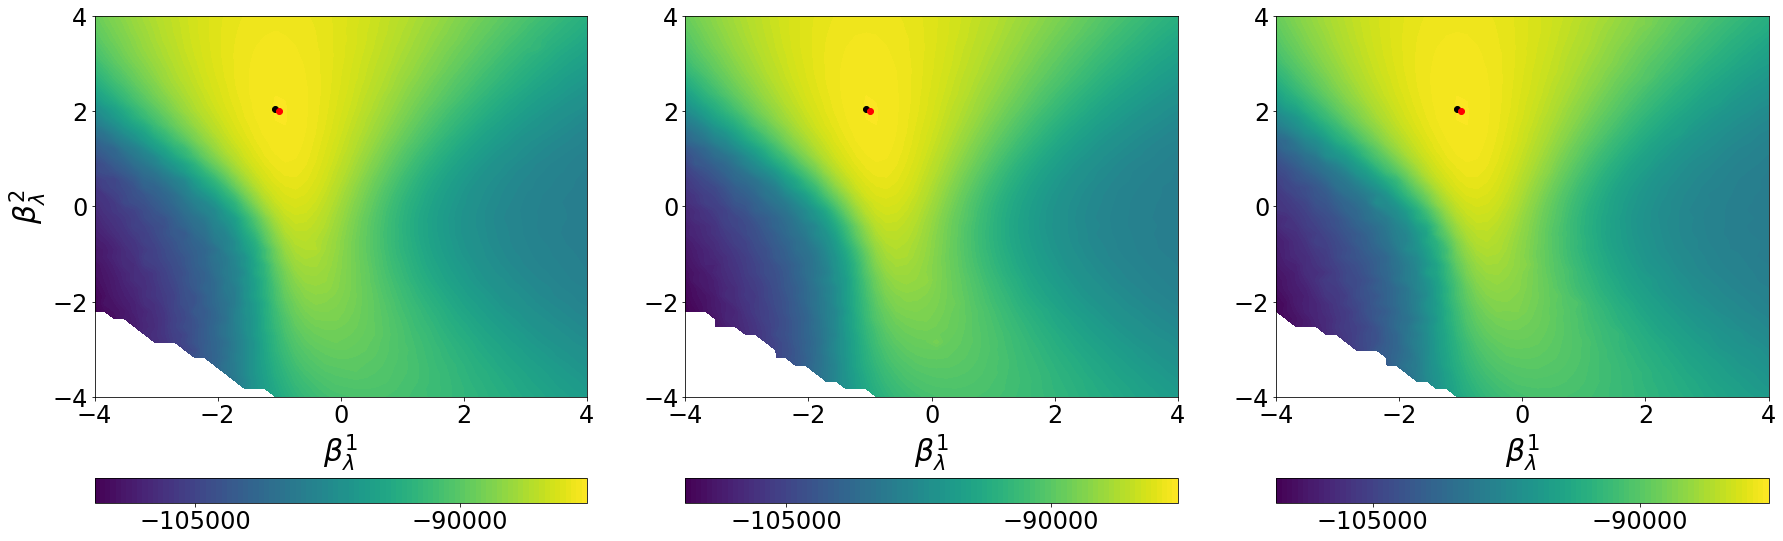

In [16]:
log_likelihood_experiments_approx_grid_beta_lambda = (np.load("data/likelihood_grid/log_likelihood_experiments_approx_grid_beta_lambda__T100_N1000_initial10_epsilon1_covmean0.npy"))
log_likelihood_experiments_coupled_grid_beta_lambda = (np.load("data/likelihood_grid/log_likelihood_experiments_coupled_grid_beta_lambda__T100_N1000_initial10_epsilon1_covmean0.npy"))
log_likelihood_experiments_grid_beta_lambda        = (np.load("data/likelihood_grid/log_likelihood_experiments_grid_beta_lambda__T100_N1000_initial10_epsilon1_covmean0.npy"))

grid_resolution = 50
beta_lambda_1 = np.linspace(-4, 4, grid_resolution)
beta_lambda_2 = np.linspace(-4, 4, grid_resolution)
beta_lambda_1_grid, beta_lambda_2_grid = np.meshgrid(beta_lambda_1, beta_lambda_2, indexing = "ij")

beta_lambda  = np.array([-1, +2])

fig, ax = plt.subplots(nrows=1, ncols =3, figsize=(30, 10))

contour1 = ax[0].contourf(beta_lambda_1_grid, beta_lambda_2_grid, log_likelihood_experiments_grid_beta_lambda, levels=100)
i,j = np.where((log_likelihood_experiments_grid_beta_lambda == np.nanmax(log_likelihood_experiments_grid_beta_lambda)))
i,j = i[0],j[0]
ax[0].scatter([beta_lambda_1_grid[i,j]], [beta_lambda_2_grid[i,j]], color = "black")
ax[0].scatter([beta_lambda[0]], [beta_lambda[1]], color = "red")
# ax[0].set_title("Without feedback")
ax[0].set_xlabel(r"$\beta_{\lambda}^{1}$")
ax[0].set_ylabel(r"$\beta_{\lambda}^{2}$")

cbar = plt.colorbar(contour1, ax = ax[0], orientation='horizontal')
cbar.locator = ticker.MaxNLocator(nbins=2)  # Show only 2 ticks
cbar.update_ticks()

contour2 = ax[1].contourf(beta_lambda_1_grid, beta_lambda_2_grid, log_likelihood_experiments_approx_grid_beta_lambda, levels=100)
i,j = np.where((log_likelihood_experiments_approx_grid_beta_lambda == np.nanmax(log_likelihood_experiments_approx_grid_beta_lambda)))
i,j = i[0],j[0]
ax[1].scatter([beta_lambda_1_grid[i,j]], [beta_lambda_2_grid[i,j]], color = "black")
ax[1].scatter([beta_lambda[0]], [beta_lambda[1]], color = "red")
# ax[1].set_title("Coupled")
ax[1].set_xlabel(r"$\beta_{\lambda}^{1}$")

cbar = plt.colorbar(contour2, ax = ax[1], orientation='horizontal')
cbar.locator = ticker.MaxNLocator(nbins=2)  # Show only 2 ticks
cbar.update_ticks()

contour3 = ax[2].contourf(beta_lambda_1_grid, beta_lambda_2_grid, log_likelihood_experiments_coupled_grid_beta_lambda, levels=100)
i,j = np.where((log_likelihood_experiments_coupled_grid_beta_lambda == np.nanmax(log_likelihood_experiments_coupled_grid_beta_lambda)))
i,j = i[0],j[0]
ax[2].scatter([beta_lambda_1_grid[i,j]], [beta_lambda_2_grid[i,j]], color = "black")
ax[2].scatter([beta_lambda[0]], [beta_lambda[1]], color = "red")
# ax[2].set_title("With feedback")
ax[2].set_xlabel(r"$\beta_{\lambda}^{1}$")

cbar = plt.colorbar(contour3, ax = ax[2], orientation='horizontal')
cbar.locator = ticker.MaxNLocator(nbins=2)  # Show only 2 ticks
cbar.update_ticks()

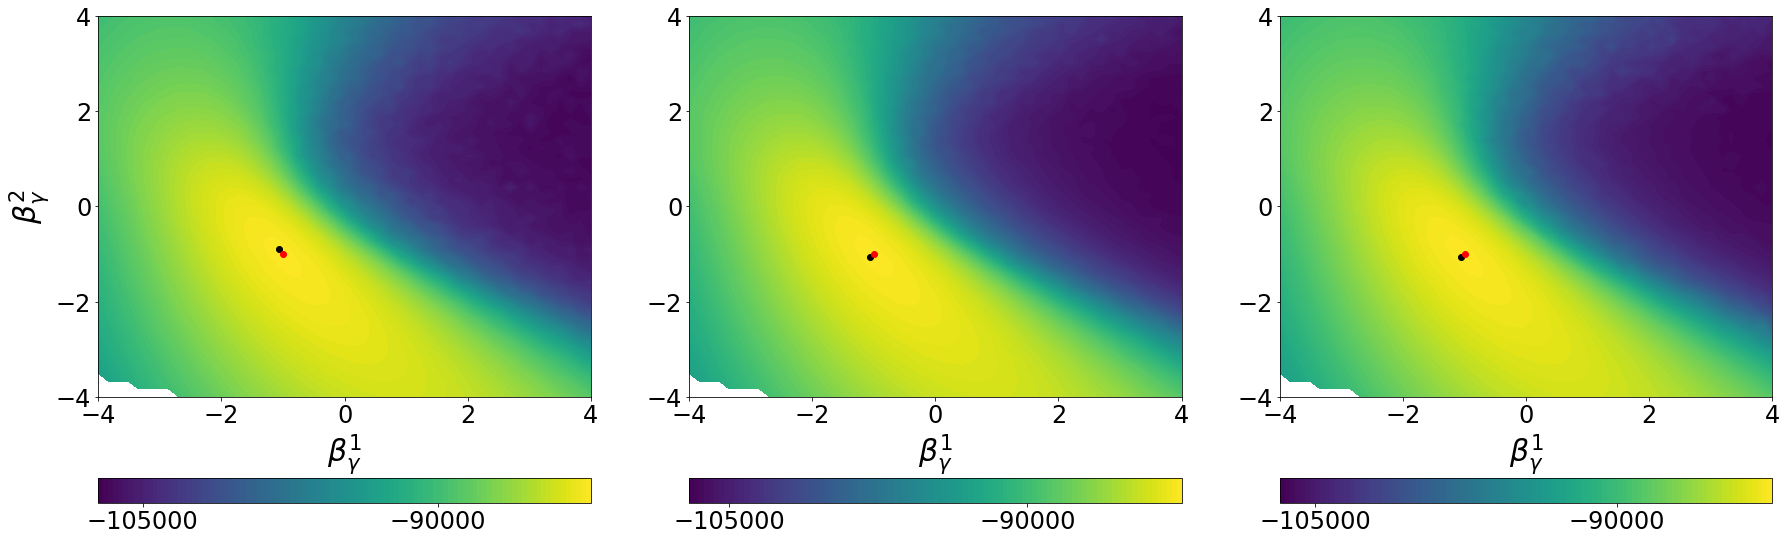

In [17]:
log_likelihood_experiments_approx_grid_beta_gamma = np.load("data/likelihood_grid/log_likelihood_experiments_approx_grid_beta_gamma__T100_N1000_initial10_epsilon1_covmean0.npy")
log_likelihood_experiments_coupled_grid_beta_gamma = np.load("data/likelihood_grid/log_likelihood_experiments_coupled_grid_beta_gamma__T100_N1000_initial10_epsilon1_covmean0.npy")
log_likelihood_experiments_grid_beta_gamma        = np.load("data/likelihood_grid/log_likelihood_experiments_grid_beta_gamma__T100_N1000_initial10_epsilon1_covmean0.npy")

grid_resolution = 50
beta_gamma_1 = np.linspace(-4, 4, grid_resolution)
beta_gamma_2 = np.linspace(-4, 4, grid_resolution)
beta_gamma_1_grid, beta_gamma_2_grid = np.meshgrid(beta_gamma_1, beta_gamma_2, indexing = "ij")

beta_gamma  = np.array([-1, -1])

fig, ax = plt.subplots(nrows=1, ncols =3, figsize=(30, 10))

contour1 = ax[0].contourf(beta_gamma_1_grid, beta_gamma_2_grid, log_likelihood_experiments_grid_beta_gamma, levels=100)
i,j = np.where((log_likelihood_experiments_grid_beta_gamma == np.nanmax(log_likelihood_experiments_grid_beta_gamma)))
i,j = i[0],j[0]
ax[0].scatter([beta_gamma_1_grid[i,j]], [beta_gamma_2_grid[i,j]], color = "black")
ax[0].scatter([beta_gamma[0]], [beta_gamma[1]], color = "red")
# ax[0].set_title("Without feedback")
ax[0].set_xlabel(r"$\beta_{\gamma}^{1}$")
ax[0].set_ylabel(r"$\beta_{\gamma}^{2}$")

cbar = plt.colorbar(contour1, ax = ax[0], orientation='horizontal')
cbar.locator = ticker.MaxNLocator(nbins=2)  # Show only 2 ticks
cbar.update_ticks()

contour2 = ax[1].contourf(beta_gamma_1_grid, beta_gamma_2_grid, log_likelihood_experiments_approx_grid_beta_gamma, levels=100)
i,j = np.where((log_likelihood_experiments_approx_grid_beta_gamma == np.nanmax(log_likelihood_experiments_approx_grid_beta_gamma)))
i,j = i[0],j[0]
ax[1].scatter([beta_gamma_1_grid[i,j]], [beta_gamma_2_grid[i,j]], color = "black")
ax[1].scatter([beta_gamma[0]], [beta_gamma[1]], color = "red")
# ax[1].set_title("Coupled")
ax[1].set_xlabel(r"$\beta_{\gamma}^{1}$")

cbar = plt.colorbar(contour2, ax = ax[1], orientation='horizontal')
cbar.locator = ticker.MaxNLocator(nbins=2)  # Show only 2 ticks
cbar.update_ticks()


contour3 = ax[2].contourf(beta_gamma_1_grid, beta_gamma_2_grid, log_likelihood_experiments_coupled_grid_beta_gamma, levels=100)
i,j = np.where((log_likelihood_experiments_coupled_grid_beta_gamma == np.nanmax(log_likelihood_experiments_coupled_grid_beta_gamma)))
i,j = i[0],j[0]
ax[2].scatter([beta_gamma_1_grid[i,j]], [beta_gamma_2_grid[i,j]], color = "black")
ax[2].scatter([beta_gamma[0]], [beta_gamma[1]], color = "red")
# ax[2].set_title("With feedback")
ax[2].set_xlabel(r"$\beta_{\gamma}^{1}$")

cbar = plt.colorbar(contour3, ax = ax[2], orientation='horizontal')
cbar.locator = ticker.MaxNLocator(nbins=2)  # Show only 2 ticks
cbar.update_ticks()

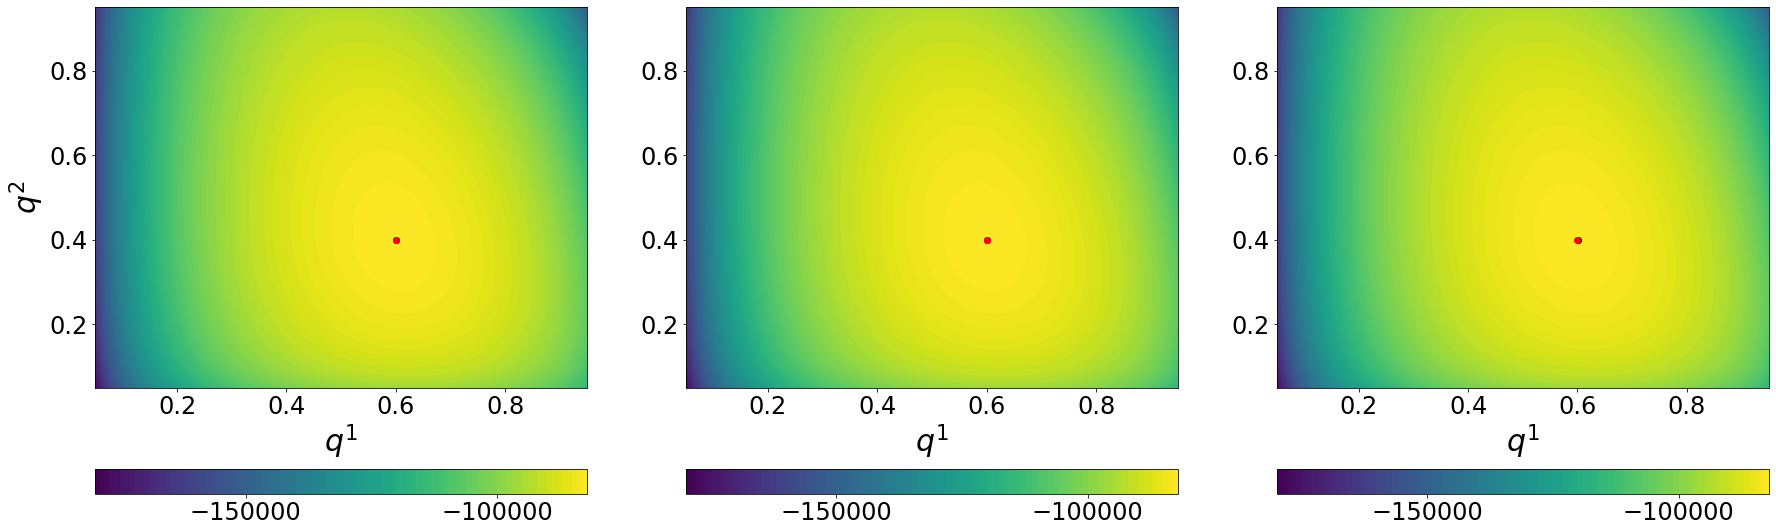

In [18]:
log_likelihood_experiments_approx_grid_q = np.load("data/likelihood_grid/log_likelihood_experiments_approx_grid_q__T100_N1000_initial10_epsilon1_covmean0.npy")
log_likelihood_experiments_coupled_grid_q = np.load("data/likelihood_grid/log_likelihood_experiments_coupled_grid_q__T100_N1000_initial10_epsilon1_covmean0.npy")
log_likelihood_experiments_grid_q        = np.load("data/likelihood_grid/log_likelihood_experiments_grid_q__T100_N1000_initial10_epsilon1_covmean0.npy")

grid_resolution = 50
q_1 = np.linspace(0.05, 0.95, grid_resolution)
q_2 = np.linspace(0.05, 0.95, grid_resolution)
q_1_grid, q_2_grid = np.meshgrid(q_1, q_2, indexing = "ij")

q  = np.array([0.6, 0.4])

fig, ax = plt.subplots(nrows=1, ncols =3, figsize=(30, 10))

contour1 = ax[0].contourf(q_1_grid, q_2_grid, log_likelihood_experiments_grid_q, levels=100)
i,j = np.where((log_likelihood_experiments_grid_q == np.nanmax(log_likelihood_experiments_grid_q)))
i,j = i[0],j[0]
ax[0].scatter([q_1_grid[i,j]], [q_2_grid[i,j]], color = "black")
ax[0].scatter([q[0]], [q[1]], color = "red")

# ax[0].set_title("Without feedback")
ax[0].set_xlabel(r"$q^{1}$")
ax[0].set_ylabel(r"$q^{2}$")

cbar = plt.colorbar(contour1, ax = ax[0], orientation='horizontal')
cbar.locator = ticker.MaxNLocator(nbins=2)  # Show only 2 ticks
cbar.update_ticks()

contour2 = ax[1].contourf(q_1_grid, q_2_grid, log_likelihood_experiments_approx_grid_q, levels=100)
i,j = np.where((log_likelihood_experiments_approx_grid_q == np.nanmax(log_likelihood_experiments_approx_grid_q)))
i,j = i[0],j[0]
ax[1].scatter([q_1_grid[i,j]], [q_2_grid[i,j]], color = "black")
ax[1].scatter([q[0]], [q[1]], color = "red")

# ax[1].set_title("Coupled")
ax[1].set_xlabel(r"$q^{1}$")

cbar = plt.colorbar(contour2, ax = ax[1], orientation='horizontal')
cbar.locator = ticker.MaxNLocator(nbins=2)  # Show only 2 ticks
cbar.update_ticks()


contour3 = ax[2].contourf(q_1_grid, q_2_grid, log_likelihood_experiments_coupled_grid_q, levels=100)
i,j = np.where((log_likelihood_experiments_coupled_grid_q == np.nanmax(log_likelihood_experiments_coupled_grid_q)))
i,j = i[0],j[0]
ax[2].scatter([q_1_grid[i,j]], [q_2_grid[i,j]], color = "black")
ax[2].scatter([q[0]], [q[1]], color = "red")

# ax[2].set_title("With feedback")
ax[2].set_xlabel(r"$q^{1}$")

cbar = plt.colorbar(contour3, ax = ax[2], orientation='horizontal')
cbar.locator = ticker.MaxNLocator(nbins=2)  # Show only 2 ticks
cbar.update_ticks()